# LowLou SPINN

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

from zpinn.create_pot import get_potential_boundary
from zpinn.pinn_nf2_cleanup import create_coordinates
from zpinn.spinn_cleanup_new import SPINN3d, generate_train_data, apply_model_spinn, update_model

<matplotlib.image.AxesImage>

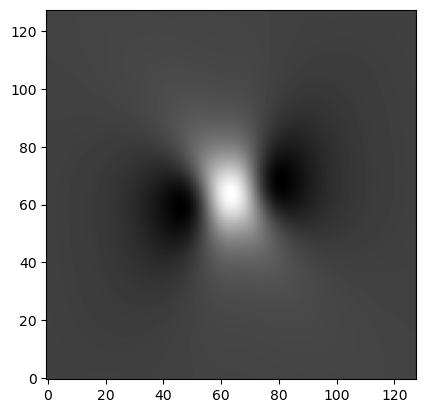

In [ ]:
input_path = '01_input/lowlou_128128128/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')

In [ ]:
output_path = '02_output/lowlou_128128128/SPINN'

Nx, Ny, _ = b_bottom.shape 
Nz = 128

b_norm = 100

In [ ]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)

boundary_npy_path = os.path.join(boundary_path, 'boundary_data.npy')

In [ ]:
epochs = 2000
log_iter = 100

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

## Create boundary data

In [ ]:
coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

b_bottom = b_bottom / b_norm
bp_top = bp_top / b_norm
bp_lateral_1 = bp_lateral_1 / b_norm
bp_lateral_2 = bp_lateral_2 / b_norm
bp_lateral_3 = bp_lateral_3 / b_norm 
bp_lateral_4 = bp_lateral_4 / b_norm

boundary_data = (b_bottom, bp_top, bp_lateral_1, bp_lateral_2, bp_lateral_3, bp_lateral_4)

with open(boundary_npy_path, 'wb') as f:
        np.save(f, boundary_data)

Potential Field: 100%|██████████| 120/120 [00:03<00:00, 36.20it/s]


## SPINN

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = np.load(f)

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='modified_mlp')
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(Nx, Ny, Nz, key)
train_boundary_data = [train_data, boundary_data]

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
params, state = update_model(optim, gradient, params, state)

In [ ]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     train_data = generate_train_data(nx, ny, nz, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0 or e == 1:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

  0%|          | 5/2000 [00:00<01:49, 18.22it/s]

Epoch: 1/2000 --> total loss: 0.18061142


  5%|▌         | 105/2000 [00:04<01:18, 24.05it/s]

Epoch: 100/2000 --> total loss: 0.16753989


 10%|█         | 205/2000 [00:08<01:15, 23.86it/s]

Epoch: 200/2000 --> total loss: 0.09575703


 15%|█▌        | 305/2000 [00:12<01:10, 24.03it/s]

Epoch: 300/2000 --> total loss: 0.04013880


 20%|██        | 405/2000 [00:16<01:07, 23.64it/s]

Epoch: 400/2000 --> total loss: 0.01514390


 25%|██▌       | 505/2000 [00:21<01:04, 23.08it/s]

Epoch: 500/2000 --> total loss: 0.00740833


 30%|███       | 602/2000 [00:25<00:58, 23.72it/s]

Epoch: 600/2000 --> total loss: 0.00431061


 35%|███▌      | 702/2000 [00:29<01:00, 21.60it/s]

Epoch: 700/2000 --> total loss: 0.00490002


 40%|████      | 805/2000 [00:33<00:50, 23.87it/s]

Epoch: 800/2000 --> total loss: 0.00210217


 45%|████▌     | 902/2000 [00:37<00:48, 22.43it/s]

Epoch: 900/2000 --> total loss: 0.00202487


 50%|█████     | 1003/2000 [00:41<00:42, 23.56it/s]

Epoch: 1000/2000 --> total loss: 0.00141769


 55%|█████▌    | 1105/2000 [00:46<00:38, 23.12it/s]

Epoch: 1100/2000 --> total loss: 0.00181509


 60%|██████    | 1204/2000 [00:50<00:32, 24.45it/s]

Epoch: 1200/2000 --> total loss: 0.00120760


 65%|██████▌   | 1305/2000 [00:54<00:29, 23.28it/s]

Epoch: 1300/2000 --> total loss: 0.00214247


 70%|███████   | 1405/2000 [00:58<00:24, 24.61it/s]

Epoch: 1400/2000 --> total loss: 0.00108596


 75%|███████▌  | 1504/2000 [01:02<00:20, 24.07it/s]

Epoch: 1500/2000 --> total loss: 0.00099140


 80%|████████  | 1604/2000 [01:06<00:16, 23.59it/s]

Epoch: 1600/2000 --> total loss: 0.00094500


 85%|████████▌ | 1703/2000 [01:10<00:12, 24.08it/s]

Epoch: 1700/2000 --> total loss: 0.00096019


 90%|█████████ | 1802/2000 [01:15<00:08, 22.00it/s]

Epoch: 1800/2000 --> total loss: 0.00084414


 95%|█████████▌| 1904/2000 [01:19<00:04, 22.32it/s]

Epoch: 1900/2000 --> total loss: 0.00083289


100%|██████████| 2000/2000 [01:23<00:00, 23.90it/s]

Epoch: 2000/2000 --> total loss: 0.00090899
Runtime --> total: 83.70sec (41.87ms/iter.)


## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import draw_grid
from zpinn.spinn_cleanup import load_spinn_mag

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/lowlou_128128128/SPINN'
vtk_path = os.path.join(eval_path, 'B_spinn.vtk')

### vtk

In [ ]:
param_path = os.path.join(output_path, f"params_{epochs}.pickle")

with open(param_path,"rb") as f:
    params = pickle.load(f)

B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

Bx = B[..., 0]
By = B[..., 1]
Bz = B[..., 2]

co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
mesh = pv.StructuredGrid(x, y, z)
vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
mesh['B'] = vectors
mesh.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
mesh['mag'] = magnitude
mesh.active_scalars_name = 'mag'

mesh

StructuredGrid (0x7f91b05a8e20)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  N Arrays:     2

In [ ]:
mesh.save(vtk_path)

### load

In [ ]:
B_spinn_mesh = pv.read(vtk_path)

In [ ]:
B_spinn_grid = draw_grid(B_spinn_mesh)

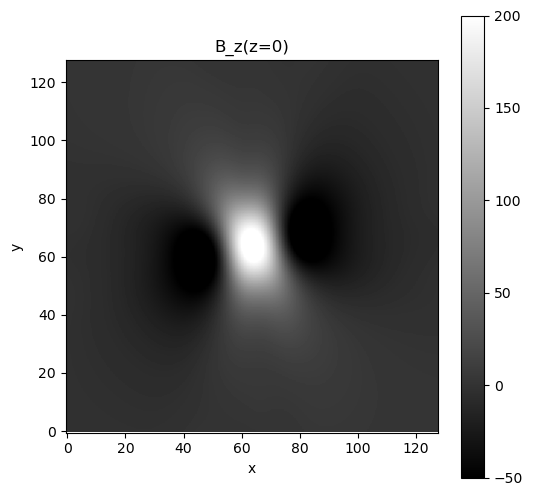

In [ ]:
B_spinn_grid.plt_Bz_imshow(z=0, vmin=-50, vmax=200)

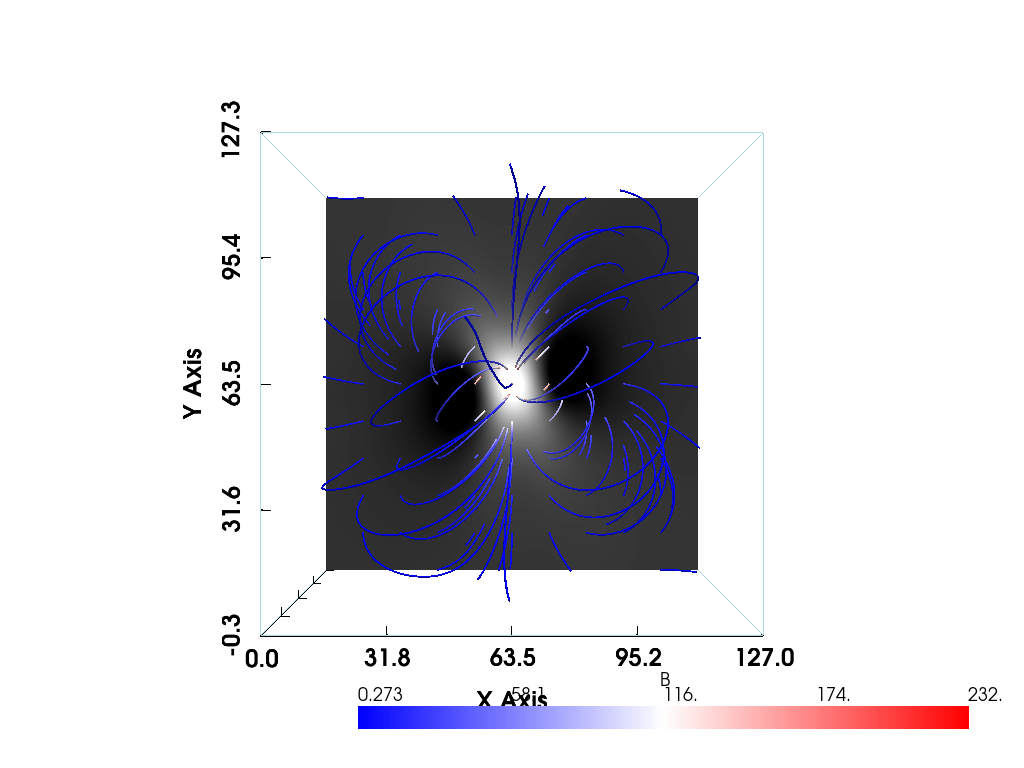

In [ ]:
B_spinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=10, j_resolution=10, vmin=-50, vmax=200)